In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

# ---------------------------------------------------------
# 1. Load Data
# ---------------------------------------------------------
participants = pd.read_csv("C3DC Participants Download 2025-11-12 16-32-53.csv")
diagnosis    = pd.read_csv("C3DC Diagnosis Download 2025-11-12 16-33-56.csv")
treatment    = pd.read_csv("C3DC Treatment Download 2025-11-12 16-34-22.csv")
survival     = pd.read_csv("C3DC Survival Download 2025-11-12 16-34-47.csv")

# ---------------------------------------------------------
# 2. CNS Tumor Flag (from Diagnosis Codes)
# ---------------------------------------------------------
cns_codes = ['C70', 'C71', 'C72']

def check_cns(site):
    if pd.isna(site):
        return 0
    s = str(site)
    return int(any(code in s for code in cns_codes))

diagnosis['is_cns_tumor'] = diagnosis['Anatomic Site'].apply(check_cns)
target_df = diagnosis.groupby('Participant ID', as_index=False)['is_cns_tumor'].max()

# ---------------------------------------------------------
# 3. Age at First Diagnosis
# ---------------------------------------------------------
diagnosis['Age_numeric'] = pd.to_numeric(diagnosis['Age at Diagnosis (days)'], errors='coerce')
age_df = diagnosis.groupby('Participant ID', as_index=False)['Age_numeric'].min()
age_df.rename(columns={'Age_numeric': 'Age_at_Diagnosis_Days'}, inplace=True)

# ---------------------------------------------------------
# 4. Treatment One-Hot Encoding
# ---------------------------------------------------------
treatment['val'] = 1

treatment_pivot = (
    treatment
    .pivot_table(
        index='Participant ID',
        columns='Treatment Type',
        values='val',
        fill_value=0,
        aggfunc='max'
    )
    .reset_index()
)

treat_cols_raw = [c for c in treatment_pivot.columns if c != 'Participant ID']
new_cols = ['Participant ID'] + [f'Treatment_{col.replace(" ", "_")}' for col in treat_cols_raw]
treatment_pivot.columns = new_cols

# ---------------------------------------------------------
# 5. Survival Data Processing
# ---------------------------------------------------------
survival['Age_Last_Contact'] = pd.to_numeric(
    survival['Age at Last Known Survival Status'], errors='coerce'
)

survival['Event_Status'] = survival['Last Known Survival Status'].apply(
    lambda x: 1 if x == 'Dead' else 0
)

survival_clean = (
    survival[['Participant ID', 'Age_Last_Contact', 'Event_Status']]
    .drop_duplicates('Participant ID')
)

# ---------------------------------------------------------
# 6. Merge All Tables
# ---------------------------------------------------------
df_merged = participants.merge(target_df, on='Participant ID', how='left')
df_merged = df_merged.merge(age_df, on='Participant ID', how='left')
df_merged = df_merged.merge(treatment_pivot, on='Participant ID', how='left')
df_merged = df_merged.merge(survival_clean, on='Participant ID', how='left')

# ---------------------------------------------------------
# 7. Basic Cleaning
# ---------------------------------------------------------
df_merged = df_merged.dropna(subset=['is_cns_tumor'])

median_age = df_merged['Age_at_Diagnosis_Days'].median()
df_merged['Age_missing_flag'] = df_merged['Age_at_Diagnosis_Days'].isna().astype(int)
df_merged['Age_at_Diagnosis_Days'] = df_merged['Age_at_Diagnosis_Days'].fillna(median_age)

treat_cols = [c for c in df_merged.columns if c.startswith('Treatment_')]
df_merged[treat_cols] = df_merged[treat_cols].fillna(0).astype(int)

categorical_cols = ['Race', 'Sex at Birth']
for col in categorical_cols:
    df_merged[col] = df_merged[col].fillna('Unknown')
    df_merged[col] = df_merged[col].replace('Not Reported', 'Unknown')

# ---------------------------------------------------------
# 8. Survival Time & 2-Year Binary Target
# ---------------------------------------------------------
df_merged['Survival_Time_Days'] = (
    df_merged['Age_Last_Contact'] - df_merged['Age_at_Diagnosis_Days']
)

df_merged.loc[df_merged['Survival_Time_Days'] < 0, 'Survival_Time_Days'] = np.nan

THRESHOLD = 730

df_merged['Target'] = np.where(
    (df_merged['Event_Status'] == 1) & (df_merged['Survival_Time_Days'] < THRESHOLD),
    1,
    0
)

# Remove censored-before-2-year cases
df_merged = df_merged[
    ~((df_merged['Event_Status'] == 0) & (df_merged['Survival_Time_Days'] < THRESHOLD))
].copy()

# ---------------------------------------------------------
# 9. Race Atomic Multi-Hot Encoding
# ---------------------------------------------------------
ATOMIC_RACES = [
    "American Indian or Alaska Native",
    "Asian",
    "Black or African American",
    "Hispanic or Latino",
    "Native Hawaiian or other Pacific Islander",
    "White",
    "Unknown"
]

def encode_atomic_races(race_str: str) -> pd.Series:
    if pd.isna(race_str):
        tokens = set()
    else:
        tokens = set(t.strip() for t in str(race_str).split(';'))
    data = {}
    for r in ATOMIC_RACES:
        data[f"Race_{r.replace(' ', '_')}"] = int(r in tokens)
    return pd.Series(data)

race_atomic_df = df_merged['Race'].apply(encode_atomic_races)

# ---------------------------------------------------------
# 10. Sex One-Hot Encoding
# ---------------------------------------------------------
sex_dummy = pd.get_dummies(df_merged['Sex at Birth'], prefix='Sex', drop_first=False)

# ---------------------------------------------------------
# 11. Final Feature Matrix
# ---------------------------------------------------------
df_final = pd.concat(
    [
        df_merged.drop(columns=['Race', 'Sex at Birth'], errors='ignore'),
        race_atomic_df,
        sex_dummy
    ],
    axis=1
)

df_final = df_final.dropna(subset=['Survival_Time_Days']).copy()

leakage_cols = ['is_cns_tumor', 'Age_Last_Contact', 'Event_Status']
df_final = df_final.drop(columns=[c for c in leakage_cols if c in df_final.columns])

df_final = df_final.drop(columns=['Study ID', 'Participant ID'], errors='ignore').copy()

# ---------------------------------------------------------
# 12. X / y Split
# ---------------------------------------------------------
X = df_final.drop(columns=['Target', 'Survival_Time_Days'])
y = df_final['Target']

print(f"Survived: {sum(y == 0)}, Dead: {sum(y == 1)}")

# ---------------------------------------------------------
# 13. Train / Test Split (Stratified)
# ---------------------------------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

# ---------------------------------------------------------
# 14. Output
# ---------------------------------------------------------
output_filename = "project_data_complete_survival_atomic_race.csv"
df_final.to_csv(output_filename, index=False)

print(f"Success! File created: {output_filename}")
print(f"Data Shape: {df_final.shape}")

Survived: 703, Dead: 117
Success! File created: project_data_complete_survival_atomic_race.csv
Data Shape: (820, 28)


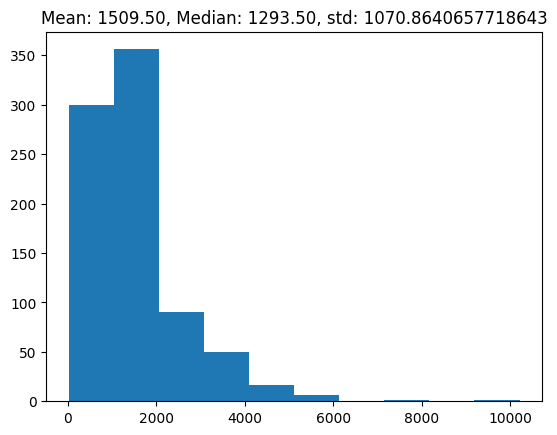

In [ ]:
y = df_final['Survival_Time_Days']
import matplotlib.pyplot as plt
plt.hist(y)
plt.title(f'Mean: {y.mean():.2f}, Median: {y.median():.2f}, std: {y.std()}')
plt.show()

2-year OS is a commonly used endpoint in pediatric CNS oncology, and given our sample’s survival distribution (median ≈ 501 days, mean ≈ 872 days), it provides a clinically meaningful separation between early mortality and longer-term survivors.

In [ ]:
#report shapes
print(f"X_train.shape : {X_train.shape}, X_test.shape : {X_test.shape }, y_train.shape : {y_train.shape}, y_test.shape : {y_test.shape}")

X_train.shape : (656, 26), X_test.shape : (164, 26), y_train.shape : (656,), y_test.shape : (164,)
